##### **Info**

***01.04.2025 by Roland Bolboaca***

1. **Dataset link:** 

    - Information about the first atasets, namely San Francisco(Caltrain) and Sao Bento(Porto).
        - Link: https://github.com/bguillouet/trajectory_classification

    - Download:

        - San Francisco Dataset: https://ieee-dataport.org/open-access/crawdad-epflmobility 

        - Porto Dataset: https://archive.ics.uci.edu/dataset/339/taxi+service+trajectory+prediction+challenge+ecml+pkdd+2015 

        - Multiple Datasets: https://dl.acm.org/doi/fullHtml/10.1145/3355283 (Table 3)

2. **Teri Preprocessed Dataset:** 
    
    - Pkl Files: 
        - datasets/porto_trajectories.pkl and porto_uci_31k_traj.pkl
        - This dataset contains a list of pandas dataframes.
        - Each datafarme contains a trajectory with 2 features (lat, lon) for now.

3. **Directories:**

    - Datasets: holds the datasets as pkl files.
    - Pkls: holds the results as pkl files (S2S and P2P, SL, HU, COMP)
    - Plots: holds the plots for the results.

4. **Flow:**

    - Create and activate venv: .\venv\Scripts\activate  
    - Check and install requirements.txt: pip install -r requirements.txt

    - Set parameters and Hyperparameters below.
    - Load Trajectory Data:
        - Load from pkl.
        - Get mins and maxs (for manual norm/denorm).
        - Create X and Y from data.
    - Create Train/Test splits:
        - Train data preparation.
        - Test data preparation.
            - Can be performed with additional testing file or by splitting a single file into train/test.
        - For each trajectory, the values are padded (end) with zeroes to a multiple of the SL (for data reshaping).
        - After inference, the padded vcalues are removed.
    - Testing flow:
        - Create LSTM/RNN/GRU models
        - Train models.
        - Test Models.
        - Compute model metrics: SE, IE, and MSE.
        - Denormalize data.
        - Plot results.

5. **Included full experiments:**
    
    - **Dynamic Sequence Length (SL):**
        - Train with a given SL, which defults to 25.
        - Test with a batch size of 1 and a SL of 25.
        - Test with a batch size of 1 and a SL of 1.
            - Can run inference in real time even with a single point.
        - Almost identical results for the above two experiments.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **SL performance analysis:**
        - Train with SLs between 3 and 40 with an increasing step of 3.
        - Test with the same SLs and a batch size of 1.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **Hidden Units (HU) performance analysis:**
        - Train with various number of HU, ranging from 2 to 64.
        - Test with the same number of HU.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **LSTM, GRU, RNN model performance analysis:**
        - Train and test the performance of the three models.
        - Denormalize, compute metrics, plot.
        - Save results.

    - **Keras training approach or manual training loop with sequence reset:**
        - Train and test the performance of both models.
        - Denormalize, compute metrics, plot.
        - Analyse results.
        

Feel free to change and enhance the code!

##### **Module Imports**

In [ ]:
import os
# oneDNN warning suppression TF 2.4.1
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import copy

import keras
import tensorflow as tf
from keras import Sequential

import numpy as np
import pandas as pd

import pickle
import gc
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.stats import energy_distance, wasserstein_distance
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from math import radians
from sklearn.metrics.pairwise import haversine_distances

##### **Parameters**

In [ ]:
SEED = 837
TESTING_SIZE = 0.2

TOTAL_TRAJS = 10000

TRAINING_TESTING_SAME_FILE = True

# DATASET = "datasets/porto_trajectories.pkl"

# DATASET = "proto_trajectories_td_200"

# DATASET = "datasets/porto_uci_31k_traj.pkl"

DATASET = "datasets/porto_uci_31k_traj_drop_only.pkl"

TESTING_FILE = None

COLUMNS = ["lat", "lon"]


##### **Hyperparameters**

In [48]:
LSTM_CELLS = 32
SEQ_LEN = 25
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.01

STATEFUL = False
RETURN_SEQ = True

NUM_FEATS = 2
NUM_OUTPUTS = 2

##### **Data Loading**

In [3]:
def save_pickle(data, data_path):
    """ Save data to a pickle file """
    
    with open(data_path, 'wb') as f:
        pickle.dump(data, f)

In [4]:
def load_pickle(data_path):
    """ Load data from file path"""
    
    with open(data_path, 'rb') as f:
        df = pickle.load(f)
    
    return df

In [5]:
def load_data_from_pickle(data_path):
    """ Load data from pickle file """
    
    df = load_pickle(data_path)
    
    return df

In [6]:
def create_X_Y_from_data(data, num_of_traj):
    
    X, Y = [0.0]  * num_of_traj, [0.0] * num_of_traj


    for i in range(num_of_traj):
        # X is composed of the trajectory data starting from the first point to the second last point
        X[i] =  data[i][COLUMNS].iloc[0:-1] 
        X[i].columns = COLUMNS

        # Y is composed of the trajectory data starting from the second point to the last point
        Y[i] =  data[i][COLUMNS].iloc[1:] 
        Y[i].columns = COLUMNS
        
        X[i] = X[i].to_numpy()
        Y[i] = Y[i].to_numpy()
        
    return X, Y

In [ ]:
def load_dummy_data():
    """ Dummy Dataset Load for custom experiments"""
    
    uri = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
    keras.utils.get_file("ds.csv","https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv" )
    filename = "ds.csv"
    urlretrieve(uri, filename)

    data_df = pd.read_csv("ds.csv")
    data_df["DateTime"] = pd.to_datetime(data_df["DateTime"])
    data_df = data_df.set_index('DateTime')
    data_df.columns = [col.strip() for col in data_df.columns]

    return data_df

##### **Data preprocessing, Normalization and Scaling**

In [7]:
def get_min_max_from_data(data):
    # Get trajectories min and max values
    num_of_traj = len(data)
    mins, maxs = [0.0] * num_of_traj, [0.0] * num_of_traj

    for i in range(num_of_traj):
        mins[i]  = np.array(data[i].min()) 
        maxs[i] = np.array(data[i].max()) 

    mins =  np.mean( np.array(mins), axis = 0)[0 : 2]
    maxs =  np.mean( np.array(maxs), axis = 0)[0 : 2]
    
    return mins, maxs, num_of_traj

In [8]:
def normalize_data(dataset, 
                   normalization_type = 'min-max',
                   normalization_ranges = None,
                   testing_data_norm = False):
    """
        Function to normalize the dataset using either min-max or standard normalization.
        Can be used for separate testing data normalization or for normalization of the whole dataset with other ranges.
        Returns the normalized dataset.
    """
    
    if normalization_type == 'min-max':   
        scaler = MinMaxScaler()
    elif normalization_type == 'standard':
        scaler = StandardScaler()
    
    # Normalize the dataset using the ranges given in normalization_ranges (min and max)        
    # Used for separate testing data normalization or for normalization of the whole dataset with other ranges
    
    if normalization_ranges is not None:
        scaler.min = normalization_ranges["min"]
        scaler.max = normalization_ranges["max"]
    else:
        scaler.fit(dataset)
        
    columns = dataset.columns
    
    norm_dataset = scaler.transform(dataset)
    norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
    
    return scaler, norm_dataset


In [9]:
def normalize_trajectory_data(dataset, 
                   normalization_type = 'min-max',
                   normalization_ranges = None,
                   testing_data_norm = False,
                   scaler = None):
    """
        Function to normalize the dataset using either min-max or standard normalization.
        Can be used for separate testing data normalization or for normalization of the whole dataset with other ranges.
        Returns the normalized dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    if testing_data_norm is False:
        if scaler is None:
            if normalization_type == 'min-max':   
                scaler = MinMaxScaler()
            elif normalization_type == 'standard':
                scaler = StandardScaler()
        
        # Normalize the dataset using the ranges given in normalization_ranges (min and max)        
        # Used for separate testing data normalization or for normalization of the whole dataset with other ranges
        
        if normalization_ranges is not None:
            X_min = normalization_ranges["min"]
            X_max = normalization_ranges["max"]
            dataset_cpy = [(arr - X_min) / (X_max - X_min) for arr in dataset_cpy]
            
        else:
            dataset_flat = pd.concat(dataset_cpy, ignore_index=True)
            # dataset_flat = np.vstack(dataset_cpy)
            scaler.fit(dataset_flat)
            
            columns = dataset_cpy[0].columns
            
            for i in range(len(dataset_cpy)):
                norm_dataset = scaler.transform(dataset_cpy[i])
                norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
                dataset_cpy[i] = norm_dataset
        
    else:
        
        if normalization_ranges is not None:
            X_min = normalization_ranges["min"]
            X_max = normalization_ranges["max"]
            dataset_cpy = [(arr - X_min) / (X_max - X_min) for arr in dataset_cpy]
            
        else:
            columns = dataset_cpy[0].columns
        
            for i in range(len(dataset_cpy)):
                norm_dataset = scaler.transform(dataset_cpy[i])
                norm_dataset = pd.DataFrame(norm_dataset, columns = columns)
                dataset_cpy[i] = norm_dataset
            
    return scaler, dataset_cpy

##### **Denormalize Data**

In [10]:
def denormalize_data(dataset, scaler = None, normalization_ranges = None):
    """
        Function to denormalize the dataset using the scaler used to normalize the dataset.
        Manual denormalization can be used for separate testing data denormalization or for denormalization of the whole dataset.
    """
    dataset_cpy = copy.deepcopy(dataset)
    
    #######
    if scaler is None and normalization_ranges is not None:
        X_min = normalization_ranges["min"]
        X_max = normalization_ranges["max"]
        
        dataset_cpy = [arr * (X_max - X_min) + X_min for arr in dataset]
            
    if scaler is not None:
        for item in range(len(dataset)):
            dataset_cpy[item] = scaler.inverse_transform(dataset_cpy[item])
       
    return dataset_cpy

##### **Data preparation**

In [11]:
def train_reshape(X, Y, 
                seq_len,
                num_feats, 
                num_outputs,
                batch_size):
    """
        Function to split the data into training and testing sets and reshape the data into the required shape for the LSTM model
        Returns a dictionary with the following:
            X_train: Training data for the input features
            X_test: Testing data for the input features
            Y_train: Training data for the output features
            Y_test: Testing data for the output features    
    """
    
    valid_rows_X = X.shape[0] // seq_len * seq_len

    if len(Y.shape) == 1:
        X = X[:valid_rows_X]
        Y = Y[:valid_rows_X]
    else:
        X = X[:valid_rows_X, :]
        Y = Y[:valid_rows_X, :]

    num_sequences_X = X.shape[0] // seq_len
       
    X = X.reshape(num_sequences_X, seq_len, num_feats)
    Y = Y.reshape(num_sequences_X, seq_len, num_outputs)
              
    X_train = X[0: X.shape[0] - (X.shape[0] % batch_size)]
    Y_train = X[0: Y.shape[0] - (Y.shape[0] % batch_size)]
       
    data = {"X_train": X_train, "Y_train": Y_train}
    
    return data

In [12]:
def create_raagged_data(X, Y, 
                        seq_len, 
                        batch_size,
                        num_trajectories):
        """
        Create a ragged dataset for the LSTM model
        Sources: 
                https://www.geeksforgeeks.org/ragged-tensors-in-tensorflow/
                https://stackoverflow.com/questions/65395179/train-and-predict-on-variable-length-sequences
        """

        # Convert to np.array. Original features are: lat and lon.
        for i in range(num_trajectories):
            X[i] = np.array(X[i])
            Y[i] = np.array(Y[i])

        # Convert to ragged tensors
        X = tf.ragged.constant(X)
        Y = tf.ragged.constant(Y)

        return X, Y

##### **Train Data Preparation**

In [13]:
def train_data_preparation(X, Y,
                            num_of_traj, 
                            BATCH_SIZE,
                            TESTING_SIZE,
                            SEQ_LEN,
                            NUM_FEATS,
                            NUM_OUTPUTS,
                            ):
    """
        Train data preparation
        Return a numpy array of all trajectories, where each trajectory is padded with zeroes to a multiple of the SL.
        After reshaping, each trajectory is a single numpy array of size (NUMBER OF SEQUENCES, SEQ_LEN, NUM_FEATS)
    """
    
    # Convert to NP Array and get the sequence lengths
    training_size = int(num_of_traj * (1 - TESTING_SIZE))
    train_traj_seq_lengths = [0.0] * training_size

    X_concatenated, Y_concatenated = [], []

    for i in range(training_size):
        X[i] = np.array(X[i])
        Y[i] = np.array(Y[i])

        # For data reshaping later on
        reminder = X[i].shape[0] % SEQ_LEN
        
        # Trim trajectories to seq_len and create a single numpy array with all trajectories
        if (X[i].shape[0] >= SEQ_LEN):
            X[i] = X[i][0 : (X[i].shape[0] - reminder), :]
            Y[i] = Y[i][0 : (Y[i].shape[0] - reminder), :]

            X_concatenated.extend(X[i])
            Y_concatenated.extend(Y[i])
        
            train_traj_seq_lengths[i] = X[i].shape[0]
            
    X_new, Y_new = np.array(X_concatenated), np.array(Y_concatenated)

    lstm_data = train_reshape(X_new, Y_new, SEQ_LEN, NUM_FEATS, NUM_OUTPUTS, BATCH_SIZE)

    X_train = lstm_data["X_train"]
    Y_train = lstm_data["Y_train"]
    
    return X_train, Y_train, training_size

##### **Test Data Preparation**

In [14]:
def test_data_preparation(TRAINING_TESTING_SAME_FILE, 
                          num_of_traj,
                          training_size,
                          SEQ_LEN,
                          NUM_FEATS,
                          TESTING_FILE,
                          data,
                          X = None, Y = None,
                          ):
    
    """
        Test data preparation
        Returns a list of numpy arrays, where each array is a single trajectory.
    """

    if TRAINING_TESTING_SAME_FILE:
        X_test = [0.0] * (num_of_traj - training_size)
        Y_test = [0.0] * (num_of_traj - training_size)

        test_traj_seq_lengths = [0.0] * (num_of_traj - training_size + 1) 

        idx = 0
        for i in range(training_size, num_of_traj):
            X[i] = np.array(X[i])
            Y[i] = np.array(Y[i])
            
            test_traj_seq_lengths[idx] = X[i].shape[0]
            
            # For data reshaping later on
            seq_multiplier = X[i].shape[0] // SEQ_LEN
            padding_size = (seq_multiplier + 1) * SEQ_LEN - X[i].shape[0]
            
            padding = np.zeros([ padding_size, NUM_FEATS ])
            
            X_test[idx] = np.vstack((X[i], padding))
            Y_test[idx] = Y[i]
            
            idx += 1
    else:
        # In case the testing data is obtained from a different file:
        data_test = load_data_from_pickle(TESTING_FILE)
        
        X_test = [0.0] * len(data_test)
        Y_test = [0.0] * len(data_test)
        
        # Get trajectories min and max values
        num_of_traj_test = len(data_test)

        test_traj_seq_lengths = [0.0] * num_of_traj_test
        
        data_test = [data_test[i][COLUMNS] for i in range(num_of_traj_test)]

        scaler, data_test = normalize_trajectory_data(dataset = data_test, normalization_type = 'min-max', testing_data_norm=True, scaler=scaler)

        X_t, Y_t = [0.0] * num_of_traj_test, [0.0] * num_of_traj_test

        for i in range(num_of_traj_test):
            # X is composed of the trajectory data starting from the first point to the second last point
            X_t[i] =  data[i][COLUMNS].iloc[0:-1] 
            X_t[i].columns = COLUMNS

            # Y is composed of the trajectory data starting from the second point to the last point
            Y_t[i] =  data[i][COLUMNS].iloc[1:] 
            Y_t[i].columns = COLUMNS

        for i in range(num_of_traj_test):
            X_t[i] = np.array(X_t[i])
            Y_t[i] = np.array(Y_t[i])

            test_traj_seq_lengths[i] = X[i].shape[0]
            
            # For data reshaping later on
            seq_multiplier = X_t[i].shape[0] // SEQ_LEN
            padding_size = (seq_multiplier + 1) * SEQ_LEN - X_t[i].shape[0]
            
            padding = np.zeros([ padding_size, NUM_FEATS ])
            
            X_test[i] = np.vstack((X_t[i], padding))
            Y_test[i] = Y_t[i]
            
    return X_test, Y_test, test_traj_seq_lengths

##### **Distance and Performance Metrics**

In [15]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
        Compute great-circle (Haversine) distance between two lat/lon points in km.
        Returns the distance in km.
    """

    # Do this check if one argument is NaN
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return 0 # 
        
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    return haversine_distances([[lat1, lon1], [lat2, lon2]])[0, 1] * 6371  #Earth radius in km


In [16]:
def haversine_distance_tdrive(lat1, lon1, lat2, lon2):
    """
        Compute great-circle (Haversine) distance between two lat/lon points in km.
        Returns the distance in km.
    """

    # Do this check if one argument is NaN
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan # 
        
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    return haversine_distances([[lat1, lon1], [lat2, lon2]])[0, 1] * 6371008.7714  #Earth radius in km

In [17]:
def compute_prediction_metrics(Y_test, Y_pred):
    """
        Compute prediction metrics for the model
        Returns a dictionary with the following metrics:
        - MSE: Mean Squared Error
        - KLD: Symetric Kullback-Leibler Divergence (Jeffreys divergence)
        - ED: Energy Distance
        - WD: Wasserstein Distance
    """
    
    # MSE, KLD, ED, WD, HAVERSINE (HS)
    mse = mean_squared_error(Y_test, Y_pred)
    # kld = keras.losses.KLDivergence(Y_test, Y_pred)
    kld = 0
    ed = float(energy_distance(Y_test, Y_pred))
    wd = float(wasserstein_distance(Y_test, Y_pred))
    
    results = {"MSE" : mse, "KLD" : kld, "ED" : ed, "WD" : wd}
    
    return results

In [18]:
def compute_trajectory_metrics(Y_test, Y_pred):
    
    """
        Compute prediction metrics for the model
        Returns a dictionary with the following metrics:
        - IE: Individual Error
        - ISE: Individual Squared Error
        - MSE: Mean Squared Error
        - ED: Energy Distance, averaged per features
    """
    
    errors = [0.0] * len(Y_test)
    squared_errors = [0.0] * len(Y_test)
    mses = [0.0] * len(Y_test)
    eds = [0.0] * len(Y_test)
    
    for i in range(len(Y_test)):
        
        err = Y_test[i] - Y_pred[i]
        squared_errors[i] = err**2
        errors[i] = err
        mses[i] = np.mean(err**2)
        
        eds1= float(energy_distance(Y_test[i][:,0], Y_pred[i][:,0]))
        eds2 = float(energy_distance(Y_test[i][:,1], Y_pred[i][:,1]))
        eds[i] = np.mean([eds1, eds2])
        
    results = {"IE" : errors, "ISE" : squared_errors, "MSE" : mses, "ED" : eds}
    
    return results

##### **Trajectory Data Plotting**

In [19]:
def plot_act_pred_traj(predicted, 
                       actual, 
                       seq_len, 
                       scatter = False, 
                       trim_trajectory = False, 
                       k=1, 
                       show = True,
                       x_range = None,
                       y_range = None):
    """
        Plots the actual and predicted trajectories.
        Set scatter to True to plot the trajectories as scatter plots.
        Set trim_trajectory to True to plot the trajectories with the same length.
        Set show to False to not show the plot.
        Saves the plot to a file.
    """
    
    if not trim_trajectory:
        LEN = seq_len
        
    fig_lons_max = max(actual.lons.max(), predicted.lons.max())
    fig_lons_min = min(actual.lons.min(), predicted.lons.min())

    fig_lats_max = max(actual.lats.max(), predicted.lats.max())
    fig_lats_min = min(actual.lats.min(), predicted.lats.min())
    
    plt.figure()
    if show == True:
        plt.show()
        
    plt.xlim([fig_lons_min, fig_lons_max])
    plt.ylim([fig_lats_min, fig_lats_max])
    
    for act, pred in zip(actual.groupby("id"), predicted.groupby("id")):
                   
        act_x, act_y = list(act[1].lons), list(act[1].lats) 
        
        if trim_trajectory:
            LEN = list(act[1].length)[0]
        
        if not scatter:
            plt.plot(act_x[0:LEN], act_y[0:LEN], marker="None", linestyle="-", linewidth=0.35, color="black")
        else:
            plt.scatter(act_x[0:LEN], act_y[0:LEN],  linewidth=0.35, color="black")
        
        pred_x, pred_y = list(pred[1].lons), list(pred[1].lats)
        
        if not scatter:
            plt.plot(pred_x[0:LEN], pred_y[0:LEN], marker="None", linestyle="-", linewidth=0.35, color="red")
        else:
            plt.scatter(pred_x[0:LEN], pred_y[0:LEN],  linewidth=0.35, color="red", alpha=0.5)
        
    plt.grid(True)
    plt.title("Actual vs. Predicted Trajectory for k = " + str(k))    
    plt.legend(["Actual", "Predicted"])
    plt.tight_layout()
    plt.savefig("plots/Predictions" + str(k) + ".pdf")

In [20]:
def plot_act_pred_traj_one_by_one(predicted, 
                                    actual, 
                                    seq_len, 
                                    scatter = True, 
                                    trim_trajectory = False, 
                                    k=1, 
                                    show = True, 
                                    num_of_traj_to_plot = 20, 
                                    start_traj = 0,
                                    end_traj = 0,
                                    x_range = None,
                                    y_range = None):
    """
        Plots the actual and predicted trajectories.
        Set scatter to True to plot the trajectories as scatter plots.
        Set trim_trajectory to True to plot the trajectories with the same length.
        Set show to False to not show the plot.
        Saves the plot to a file.
    """
           
    # fig_lons_max = max(actual.lons.max(), predicted.lons.max())
    # fig_lons_min = min(actual.lons.min(), predicted.lons.min())

    # fig_lats_max = max(actual.lats.max(), predicted.lats.max())
    # fig_lats_min = min(actual.lats.min(), predicted.lats.min())
    errors_x = []
    errors_y = []
    
    plt.figure()
    if show == True:
        plt.show()
    
    if x_range is not None:
        plt.xlim(x_range)
        
    if y_range is not None:
        plt.ylim(y_range)
    
    # plt.xlim([fig_lons_min, fig_lons_max])
    # plt.ylim([fig_lats_min, fig_lats_max])
    
    index = 0
    for act, pred in zip(actual, predicted):
        
        if end_traj != 0 and index >= start_traj and index <= end_traj:
                            
            act_x, act_y = act[:, 0], act[:, 1] 
            
            if not scatter:
                plt.plot(act_x, act_y, marker="None", linestyle="-", linewidth=0.35, color="black")
            else:
                plt.scatter(act_x, act_y,  linewidth=0.35, color="black")
            
            pred_x, pred_y = pred[:, 0], pred[:, 1]
            
            if not scatter:
                plt.plot(pred_x, pred_y, marker="None", linestyle="-", linewidth=0.35, color="red")
            else:
                plt.scatter(pred_x, pred_y,  linewidth=0.35, color="red", alpha=0.5)
            
            errors_x.append(act_x - pred_x)
            errors_y.append(act_y - pred_y)
            
        index += 1
        
    plt.grid(True)
    plt.title("Actual vs. Predicted Trajectory")    
    plt.legend(["Actual", "Predicted"])
    # plt.show()
    plt.tight_layout()
    plt.savefig("plots/Predictions" + str(k) + ".pdf")

##### **Create LSTM and Recurrent Models**

In [21]:
def create_LSTM_model(LSTM_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an LSTM model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.LSTM(LSTM_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.LSTM(LSTM_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 40,
        decay_rate = 0.96) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  metrics = ["mse", "mae", "mape", "kl_divergence"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

In [22]:
def create_RNN_model(RNN_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an LSTM model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.RNN(RNN_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.RNN(RNN_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 40,
        decay_rate = 0.96) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  metrics = ["mse", "mae", "mape", "kl_divergence"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

In [23]:
def create_GRU_model(GRU_cells, 
                      seq_len, 
                      num_feat,
                      batch_size,
                      stateful,
                      return_seq,
                      num_outputs,
                      LR,
                      SEED,
                      ragged = False):
    """
        Create an GRU model with the specified parameters
        Returns the untrained model
    """
    
    keras.utils.set_random_seed(SEED)

    # In newer versions of Keras, for stateful LSTM, you need to specify the batch_input_shape as the first layer (input layer)
    model = Sequential()
    
    # Ragged tensor for variable length sequences
    if ragged is False:
        model.add(keras.layers.InputLayer(batch_input_shape=(batch_size, seq_len, num_feat)))
        model.add(keras.layers.GRU(GRU_cells, return_sequences = return_seq, stateful = stateful))
    else:
        model.add(keras.layers.InputLayer(shape=[None, num_feat], batch_size = batch_size, dtype=tf.float32, ragged = True))
        model.add(keras.layers.GRU(GRU_cells, return_sequences = return_seq, stateful = False))
        
    model.add(keras.layers.Dense(num_outputs))
    
    
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR,
        decay_steps = 40,
        decay_rate = 0.96) 
    
    model.compile(optimizer = "adam", 
                  loss = "mse", 
                  metrics = ["mse", "mae", "mape", "kl_divergence"])
    
    # https://keras.io/api/optimizers/
    model.optimizer.lr=lr_schedule
    # mdl.optimizer.momentum = 0.99
    # mdl.optimizer.use_ema = True

    return model

##### **Train LSTM Models**

In [24]:
# Keras training loop
def train_model(model, 
                X_train, Y_train, 
                epochs,
                batch_size):
    """
        Train the LSTM model with the default keras method
        Returns the training history and the trained model
    """
    history = model.fit(X_train, 
                        Y_train, 
                        batch_size = batch_size, 
                        epochs = epochs, 
                        verbose = 0, 
                        shuffle = False)
        
    return history, model

In [25]:
# Manual training loop
def train_model_manual_loop(model, 
                            epochs,
                            LR,
                            batch_size,
                            X_train = None,
                            Y_train = None,
                            reset_states = True):
    """
        Manual training loop for the LSTM model
        Works with the model created with the create_LSTM_model function
        Works for any batch size
        Returns the training history and the trained model
    """
    
    loss_fn = keras.losses.MeanSquaredError()
    
    optimizer = model.optimizer
        
    for epoch in range(epochs):
        for step in range(0, len(X_train), batch_size):

            x_batch = X_train[step : step + batch_size]  
            y_batch = Y_train[step : step + batch_size]  

            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)

            # Get gradients
            trainable_vars = model.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Apply gradients to update model weights
            optimizer.apply_gradients(zip(gradients, trainable_vars))
            
            # Reset states after batch
            if reset_states:
                model.reset_states()
            
    return model.history, model

In [26]:
# Manual training loop with sequence resets
def train_model_train_on_batch(model, 
                                X, Y, 
                                batch_size , 
                                epochs):
    """
        Manual training loop with sequence resets and train on batch
        Works for stateful and stateless models
        Works for any batch size
        Returns the trained model
    """
    # Manual training loop with sequence resets used with train_on_baatch
    for epoch in range(epochs):
        for start in range(0, len(X), batch_size):
            model.train_on_batch(X[start : start + batch_size], Y[start : start + batch_size])
            model.reset_states()
        
    return model

##### **Test LSTM Models**

In [27]:
def test_model(model, 
               X_test, 
               Y_test, 
               batch_size):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    
    Y_pred = model.predict(X_test, batch_size = batch_size, verbose = 0).reshape(-1, 1).flatten()
    Y_test = Y_test.reshape(-1, 1).flatten()
    
    return Y_test, Y_pred

In [28]:
def test_model_per_trajectory(mdl, 
                            X_t, 
                            Y_t,
                            test_traj_seq_lengths,
                            SEQ_LENGTH,
                            NUM_FEATS
                            ):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    mdl.layers[0].reset_states()
    
    Y_preds = [0.0] * len(X_t)

    for i in range(len(X_t)):
        X_t[i] = X_t[i].reshape(-1, SEQ_LENGTH, NUM_FEATS)
    
    for i in range(len(X_t)):
        
        y_pred = mdl.predict(X_t[i], batch_size = 1, verbose = 0).reshape(-1, NUM_FEATS)
        y_pred = y_pred[0:test_traj_seq_lengths[i], :]
        Y_preds[i] = y_pred
        
        mdl.layers[0].reset_states()
        
    return Y_preds

In [29]:
def test_model_all_trajectories(model, 
                                X_test, 
                                Y_test, 
                                batch_size):
    """
        Works for both stateful and non-stateful models
        Works for any batch size
        Returns the predictions of the model on the test data
    """
    
    Y_pred = model.predict(X_test, batch_size = batch_size).reshape(-1, 1).flatten()
    Y_test = Y_test.reshape(-1, 1).flatten()
   
    return Y_test, Y_pred

**General Test with Dummy Data**

In [ ]:
%%script true --no-raise-error
%%cache 

data = load_dummy_data()
scaler,data = normalize_data(dataset = data, normalization_type = 'min-max')

feature_cols = 'Temperature'
target_col = 'Zone 1 Power Consumption'

X = data[feature_cols].values
Y = data[target_col].values

X = X[0:5000]
Y = Y[0:5000]

data = train_test_split_fun(X = X, Y = Y,
                            testing_size = 0.2, 
                            seq_len = SEQ_LEN, 
                            num_feats = NUM_FEATS, 
                            num_outputs = NUM_OUTPUTS, 
                            batch_size = BATCH_SIZE)

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

model = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = BATCH_SIZE,
                          stateful = STATEFUL,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED)

history, model = train_model(model = model,
                    X_train = X_train,
                    Y_train = Y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE)

Y_test, Y_pred = test_model(model,
                            X_test = X_test,
                            Y_test = Y_test,
                            batch_size = BATCH_SIZE)

results = compute_prediction_metrics(Y_test = Y_test, Y_pred = Y_pred)

print(results)

## **Experiments**

##### **Load Trajectory Data Once**

In [49]:
# Load trajectory data for faster execution
data = load_data_from_pickle(DATASET)

# Remove trajectory 2873 from data for California dataset
# data.pop(2873)

# Get trajectories min and max values
mins, maxs, num_of_traj =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Create X and Y from the data
X, Y =  create_X_Y_from_data(data, num_of_traj)

##### **Create Trajectory Data Training/Testing Splits**

In [50]:
# Train Data Preparation
X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y= copy.deepcopy(Y),
                                                        num_of_traj = num_of_traj,
                                                        BATCH_SIZE = BATCH_SIZE,
                                                        TESTING_SIZE = TESTING_SIZE,
                                                        SEQ_LEN = SEQ_LEN,
                                                        NUM_FEATS = NUM_FEATS,
                                                        NUM_OUTPUTS = NUM_OUTPUTS)

In [51]:
# Test Data Preparation
X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                X = copy.deepcopy(X), Y = copy.deepcopy(Y),
                                                                num_of_traj = num_of_traj,
                                                                training_size = training_size,
                                                                SEQ_LEN = SEQ_LEN,
                                                                NUM_FEATS = NUM_FEATS,
                                                                TESTING_FILE = None,
                                                                data = data)

pass

##### **Dynamic Sequence Length Analysis (Train with BS > 1 and test with BS = 1)**

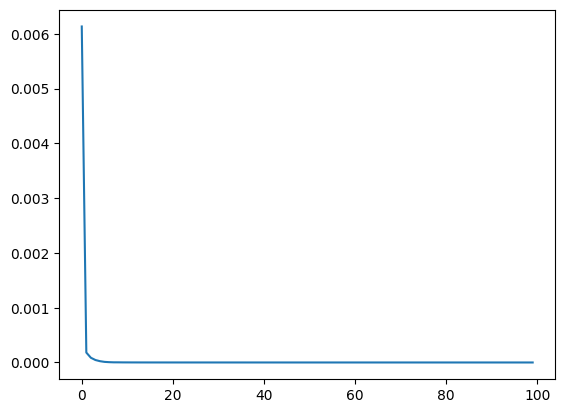

In [52]:
"""
    Train the LSTM model with a given BS > 1 and test it with BS = 1
    The original model is copied to another model with BS = 1 (weights and states are copied)
    The script can be executed with any BS or SL. However, one must modify and execute the parameter block to update the SL and BS!
"""

# Model TRAINING:

# Test with BS = 1 si BS > 1
mdl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = BATCH_SIZE,
                          stateful = STATEFUL,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Train the model
history, mdl1 = train_model(model = mdl1,
                    X_train = X_train,
                    Y_train = Y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE)

# Plot the loss of the model
plt.plot(history.history["loss"])

In [53]:
# Model TESTING:

"""
    Test the model with BS = 1
    
    Returns:
        Y_Test and Y_pred: List of numpy arrays of length of the original trajectories without zero padding.
"""

# Model for BS = 1
model_sl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Set weights and states
model_sl1.set_weights(mdl1.get_weights())
# model_sl1.layers[0].states = model.layers[0].states

In [54]:
# Test a model with seq-to-seq approach
Y_pred_1 = test_model_per_trajectory(mdl = model_sl1,
                                        X_t = X_test,
                                        Y_t = Y_test,
                                        test_traj_seq_lengths = test_traj_seq_lengths,
                                        SEQ_LENGTH = SEQ_LEN,
                                        NUM_FEATS = NUM_FEATS)


In [55]:
results_1 = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred_1)

In [ ]:
# Model TESTING:

"""
    Test the model with BS = 1 ans SL1
    
    Returns:
        Y_Test and Y_pred: List of numpy arrays of length of the original trajectories without zero padding.
"""

model_sl2 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Set weights and states
model_sl2.set_weights(mdl1.get_weights())

In [ ]:
# Test the model with a point-to-point approach approach
Y_pred_2 = test_model_per_trajectory(mdl = model_sl2,
                                            X_t = X_test,
                                            Y_t = Y_test,
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS)

In [ ]:
results_2 = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred_2)

In [ ]:
# Denormalize data

# Deep copy Y_test and Y_pred_1 and Y_pred_2 to avoid overwriting the original data
Y_test_cp = copy.deepcopy(Y_test)
Y_pred_1_cp = copy.deepcopy(Y_pred_1)

# Denormalize the data using the scaler or normalization ranges
Y_test_1_dn = denormalize_data(dataset = Y_test_cp, scaler = scaler)
Y_pred_1_dn = denormalize_data(dataset = Y_pred_1_cp, scaler = scaler)

# For Point-by-point prediction
# Y_pred_2_cp = copy.deepcopy(Y_pred_2)
# Y_pred_2_dn = denormalize_data(dataset = Y_pred_2_cp, scaler = scaler)

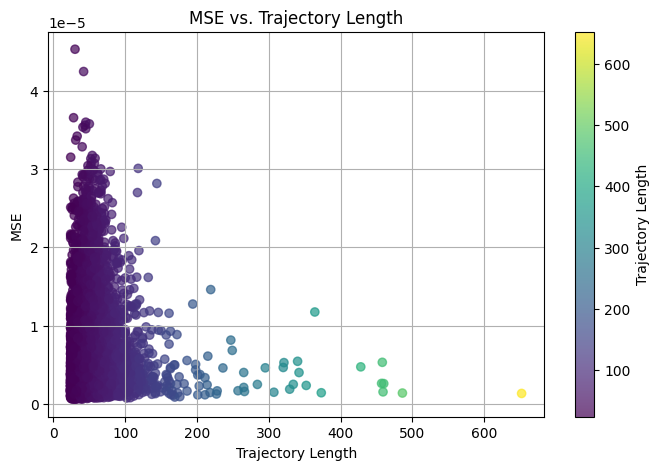

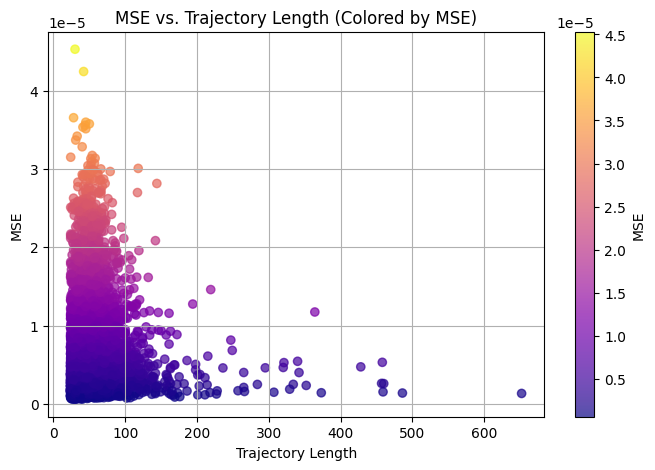

In [ ]:
# Trajectory Prediction Analysis

# Input: test_traj_seq_lengths
# Inputs: MSE_values

mse_values = results_1["MSE"]
lengths = test_traj_seq_lengths[0:len(mse_values)]

# Params (font sizes) settings.
plt.rcParams.update({'font.size': 18,  # General font size
                     'axes.labelsize': 18,  # Axis labels
                     'axes.titlesize': 18,  # Title size
                     'xtick.labelsize': 18,  # X-tick labels
                     'ytick.labelsize': 16  # Y-tick labels
                    })

plt.figure(figsize=(8, 5))
scatter = plt.scatter(lengths, mse_values, c=lengths, cmap='viridis', alpha=0.7)
plt.xlabel("Trajectory Length")
plt.ylabel("MSE")
plt.title("MSE vs. Trajectory Length")
plt.colorbar(scatter, label='Trajectory Length')
plt.grid(True)
plt.show()


mse_values = results_1["MSE"]
lengths = test_traj_seq_lengths[0:len(mse_values)]

plt.figure(figsize=(8, 5))
scatter = plt.scatter(lengths, mse_values, c=mse_values, cmap='plasma', alpha=0.7)
plt.xlabel("Trajectory Length")
plt.ylabel("MSE")
plt.title("MSE vs. Trajectory Length (Colored by MSE)")
plt.colorbar(scatter, label='MSE')
plt.grid(True)
plt.show()


##### **Sequence Length Performence Analysis**

In [ ]:
""" 
    Testing loop for sequence lengths 5-40 step 3
    Returns: results_SL_y_pred, results_SL_y_test
        
        Results are stored in a dictionary with the key as the SL and a list that contains:
            - For each trajectory, the actual and predicted points as numpy arrays (of shape trajectory_length x 2).
        Data is stored denormalized!
"""

# Testing loop
results_SL_y_test = dict()
results_SL_y_pred = dict()
results_SL_metrics = dict()

# Load trajectory data for faster execution, get min and max values for normalization, and create X and Y data
data = load_data_from_pickle(DATASET)

# Get min and max values for normalization
mins, maxs, num_of_traj =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Create X and Y from the data
X, Y =  create_X_Y_from_data(data, num_of_traj)

for sequence_length in range(3, 41, 3):
    
    # Print the sequence length    
    print("SL: " + str(sequence_length))
    
    # Create data for each SL value
    X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
                                                                    num_of_traj = num_of_traj,
                                                                    BATCH_SIZE = BATCH_SIZE,
                                                                    TESTING_SIZE = TESTING_SIZE,
                                                                    SEQ_LEN = sequence_length,
                                                                    NUM_FEATS = NUM_FEATS,
                                                                    NUM_OUTPUTS = NUM_OUTPUTS)
    
    
    X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                    X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
                                                                    num_of_traj = num_of_traj,
                                                                    training_size = training_size,
                                                                    SEQ_LEN = sequence_length,
                                                                    NUM_FEATS = NUM_FEATS,
                                                                    TESTING_FILE = None,
                                                                    data = data)
    
    # Model TRAINING:
    # Test with SL = 1 si SL > 1
    mdl = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                            seq_len = sequence_length,
                            num_feat = NUM_FEATS,
                            batch_size = BATCH_SIZE,
                            stateful = STATEFUL,
                            return_seq = RETURN_SEQ,
                            num_outputs = NUM_OUTPUTS,
                            LR = LR,
                            SEED = SEED,
                            ragged = False)

    # Train the model
    history, mdl = train_model(model = mdl,
                        X_train = X_train,
                        Y_train = Y_train,
                        epochs = EPOCHS,
                        batch_size = BATCH_SIZE)
    
    # Model for SL = 1
    model_sl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                                    seq_len = sequence_length,
                                    num_feat = NUM_FEATS,
                                    batch_size = 1,
                                    stateful = True,
                                    return_seq = RETURN_SEQ,
                                    num_outputs = NUM_OUTPUTS,
                                    LR = LR,
                                    SEED = SEED,
                                    ragged = False)

    # Set weights and states
    model_sl1.set_weights(mdl.get_weights())

    # Test the model
    Y_pred = test_model_per_trajectory(mdl = model_sl1,
                                        X_t = X_test,
                                        Y_t = Y_test,
                                        test_traj_seq_lengths = test_traj_seq_lengths,
                                        SEQ_LENGTH = sequence_length,
                                        NUM_FEATS = NUM_FEATS)
    
    results = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred)
    
    # Denormalize data   
    # Deep copy Y_test and Y_pred to avoid overwriting the original data
    Y_test_cp = copy.deepcopy(Y_test)
    Y_pred_cp = copy.deepcopy(Y_pred)
    
    Y_test_dn_sl = denormalize_data(dataset=Y_test_cp, scaler=scaler)
    Y_pred_dn_sl = denormalize_data(dataset=Y_pred_cp, scaler=scaler)
    
    results_SL_y_test[sequence_length] = Y_test_dn_sl
    results_SL_y_pred[sequence_length] = Y_pred_dn_sl
    results_SL_metrics[sequence_length] = results
    
    # Clear the model and reset 
    gc.collect()
    keras.backend.clear_session()   

# Save the results
path_2 = "pkls/SL/"

# For model testing SL analysis
save_pickle(results_SL_y_test, path_2 + "results_SL_y_test.pkl")
save_pickle(results_SL_y_pred, path_2 + "results_SL_y_pred.pkl")
save_pickle(results_SL_metrics, path_2 + "results_SL_metrics.pkl")

SL: 3

SL: 6
SL: 9
SL: 12
SL: 15


In [ ]:
# Results Analysis
path_2 = "pkls/SL/"

results_SL_y_test = load_pickle(path_2 + "results_SL_y_test.pkl")
results_SL_y_pred = load_pickle(path_2 + "results_SL_y_pred.pkl")
results_SL_metrics = load_pickle(path_2 + "results_SL_metrics.pkl")

# Results are stored in a dictionary with the key as the SL and a list that contains:
#     - For each trajectory, the actual and predicted points as numpy arrays (of shape trajectory_length x 2).

# Plot the results as follows: on the x axis the SL and on the y axis the error MSE.
#   A line for each trajectory and a point for each SL value.

METRIC = "MSE"
METRIC = "ED"

# Global font size variables for Figures 2 and 3.
FONT_SIZE = 18
LABEL_FONT_SIZE = 18
TITLE_FONT_SIZE = 18
TICK_LABEL_SIZE = 16


# Figure 1: 3D plot of the selected metric for each trajectory per sequence length

# Params (font sizes) settings.
plt.rcParams.update({'font.size': 12,  # General font size
                     'axes.labelsize': 12,  # Axis labels
                     'axes.titlesize': 12,  # Title size
                     'xtick.labelsize': 10,  # X-tick labels
                     'ytick.labelsize': 12  # Y-tick labels
                    })

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for seq_len, metrics in results_SL_metrics.items():
    seq_len = int(seq_len)
    mse_list = metrics.get(METRIC, [])
    xs = [seq_len] * len(mse_list)
    ys = range(len(mse_list))
    zs = mse_list
    ax.scatter(xs, ys, zs, s=25, alpha=0.7)

ax.set_xlabel('Sequence Length')
ax.set_ylabel('Trajectory Index')

ax.set_zlabel(METRIC)
ax.zaxis.labelpad = 8  

# Set x-ticks to be the actual sequence lengths in the data
n = 2  
sequence_lengths = list(results_SL_metrics.keys())
ax.set_xticks(sequence_lengths[::n]) 

# Adjust tick parameters
ax.set_title(METRIC + ' per Trajectory per Sequence Length')

ax.tick_params(axis='z', labelsize=12)

plt.subplots_adjust(left=0.01, right=0.2, bottom=0.1, top=0.2)
plt.tight_layout()

# Save the figure
plt.savefig("plots/SL_"+ METRIC + "_3D.pdf")


# Figure 2: Scatter plot of the selected metric for each trajectory per sequence length
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Create scatter plot for each sequence length
for seq_len, metrics in results_SL_metrics.items():
    seq_len = int(seq_len)
    mse_list = metrics.get(METRIC, [])
    
    ax1.scatter([seq_len] * len(mse_list), mse_list, marker='o', s = 80, alpha=0.9, color=plt.cm.tab20(seq_len % 20 / 20))

ax1.set_xlabel('Sequence Length', fontsize=LABEL_FONT_SIZE)
ax1.set_ylabel(METRIC, fontsize=LABEL_FONT_SIZE)
ax1.set_title(METRIC + ' for Each Trajectory per Sequence Length', fontsize=TITLE_FONT_SIZE)

# Set custom x-axis ticks (sequence lengths)
ax1.set_xticks(list(results_SL_metrics.keys())) 
ax1.set_xticklabels(list(results_SL_metrics.keys()))  

# Adjust tick labels font size
ax1.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)
plt.grid(True)

# Save the figure
plt.tight_layout()
fig1.savefig("plots/SL_" + METRIC + "_Traj.pdf")



# Figure 3: Average metric per sequence length
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Calculate average MSE per sequence length
avg_mse_per_seq_len = {}
for seq_len, metrics in results_SL_metrics.items():
    mse_list = metrics.get(METRIC, [])
    avg_mse_per_seq_len[seq_len] = np.mean(mse_list)  

# Convert dictionary to arrays for plotting
seq_lengths = list(avg_mse_per_seq_len.keys())
avg_mse_values = list(avg_mse_per_seq_len.values())

# Plot the average MSE values
ax2.plot(seq_lengths, avg_mse_values, marker='o', markersize = 8, linewidth=3)

# Setting labels and title using global font sizes
ax2.set_xlabel('Sequence Length', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('Average ' + METRIC, fontsize=LABEL_FONT_SIZE)
ax2.set_title('Average ' + METRIC + ' per Sequence Length', fontsize=TITLE_FONT_SIZE)

ax2.set_xticks(seq_lengths)  
ax2.set_xticklabels(seq_lengths)

ax2.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)

plt.grid(True)

# Save the figure
plt.tight_layout()
fig2.savefig("plots/SL_"+ METRIC + "_AVG.pdf")


##### **LSTM Architecture: Hidden Units**

In [ ]:
"""
    Testing loop for different number of hidden units 2-64 step 4.
    Returns: results_CELLS_y_pred, results_CELLS_y_test
    
    Results are stored in a dictionary with the key as the number of hidden units and a list that contains:
        - For each trajectory, the actual and predicted points as numpy arrays (of shape trajectory_length x 2).
     Data is stored denormalized!
"""

# Testing loop
results_CELLS_y_test = dict()
results_CELLS_y_pred = dict()
results_CELLS_metrics = dict()


# Load trajectory data for faster execution, get min and max values for normalization, and create X and Y data
data = load_data_from_pickle(DATASET)

# Get min and max values for normalization
mins, maxs, num_of_traj =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Create X and Y from the data
X, Y =  create_X_Y_from_data(data, num_of_traj)

# Create data for each SL value
X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
                                                                num_of_traj = num_of_traj,
                                                                BATCH_SIZE = BATCH_SIZE,
                                                                TESTING_SIZE = TESTING_SIZE,
                                                                SEQ_LEN = SEQ_LEN,
                                                                NUM_FEATS = NUM_FEATS,
                                                                NUM_OUTPUTS = NUM_OUTPUTS)


X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
                                                                num_of_traj = num_of_traj,
                                                                training_size = training_size,
                                                                SEQ_LEN = SEQ_LEN,
                                                                NUM_FEATS = NUM_FEATS,
                                                                TESTING_FILE = None,
                                                                data = data)
    
for cells in range(2, 65, 2 ): #4
    
    print("LSTM_CELLS: " + str(cells))
    
    
    # Model TRAINING:
    model_c = create_LSTM_model(LSTM_cells = cells,
                                seq_len = SEQ_LEN,
                                num_feat = NUM_FEATS,
                                batch_size = BATCH_SIZE,
                                stateful = STATEFUL,
                                return_seq = RETURN_SEQ,
                                num_outputs = NUM_OUTPUTS,
                                LR = LR,
                                SEED = SEED,
                                ragged = False)

    # Train the model
    history, model_c = train_model(model = model_c,
                                    X_train = X_train,
                                    Y_train = Y_train,
                                    epochs = EPOCHS,
                                    batch_size = BATCH_SIZE)

    # Plot the loss of the model
    # plt.plot(history.history["loss"])

    
    # Model for SL = 1
    model_sl1 = create_LSTM_model(LSTM_cells = cells,
                                    seq_len = SEQ_LEN,
                                    num_feat = NUM_FEATS,
                                    batch_size = 1,
                                    stateful = True,
                                    return_seq = RETURN_SEQ,
                                    num_outputs = NUM_OUTPUTS,
                                    LR = LR,
                                    SEED = SEED,
                                    ragged = False)

    # Set weights and states
    model_sl1.set_weights(model_c.get_weights())

    # Test the model
    Y_pred = test_model_per_trajectory(mdl = model_sl1,
                                            X_t = X_test,
                                            Y_t = Y_test,
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = SEQ_LEN,
                                            NUM_FEATS = NUM_FEATS)
    
    # res = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred)
    results = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred)
    
    # Create deep copy Y_test and Y_pred to avoid overwriting the original data
    Y_test_cp = copy.deepcopy(Y_test)
    Y_pred_cp = copy.deepcopy(Y_pred)
    
    Y_test_dn_cells = denormalize_data(dataset=Y_test_cp, scaler=scaler)
    Y_pred_dn_cells = denormalize_data(dataset=Y_pred_cp, scaler=scaler)
    
    results_CELLS_y_test[cells] = Y_test_dn_cells
    results_CELLS_y_pred[cells] = Y_pred_dn_cells
    results_CELLS_metrics[cells] = results
    
    # Clear the model and reset 
    gc.collect()
    keras.backend.clear_session()   

path_3 = "pkls/CELLS/"
# For model testing CELLS analysis
save_pickle(results_CELLS_y_test, path_3 + "results_CELLS_y_test.pkl")
save_pickle(results_CELLS_y_pred, path_3 + "results_CELLS_y_pred.pkl")
save_pickle(results_CELLS_metrics, path_3 + "results_CELLS_metrics.pkl")


In [ ]:
# Results Analysis
path_3 = "pkls/CELLS/"

# results_CELLS_y_test = load_data_from_pickle(path_3 + "results_CELLS_y_test.pkl")
# results_CELLS_y_pred = load_data_from_pickle(path_3 + "results_CELLS_y_pred.pkl")
# results_CELLS_metrics = load_data_from_pickle(path_3 + "results_CELLS_metrics.pkl")

# Results are stored in a dictionary with the key as the HU and a list that contains:
#     - For each trajectory, the actual and predicted points as numpy arrays (of shape trajectory_length x 2).

# Plot the results as follows: on the x axis the HU and on the y axis the error MSE.
#   A line for each trajectory and a point for each HU value.

METRIC = "MSE"
# METRIC = "ED"

# Global font size variables for Figures 2 and 3.
FONT_SIZE = 18
LABEL_FONT_SIZE = 18
TITLE_FONT_SIZE = 18
TICK_LABEL_SIZE = 16


# Figure 1: 3D plot of the selected metric for each trajectory per sequence length

# Params (font sizes) settings.
plt.rcParams.update({'font.size': 12,  # General font size
                     'axes.labelsize': 12,  # Axis labels
                     'axes.titlesize': 12,  # Title size
                     'xtick.labelsize': 10,  # X-tick labels
                     'ytick.labelsize': 12  # Y-tick labels
                    })

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for seq_len, metrics in results_CELLS_metrics.items():
    seq_len = int(seq_len)
    mse_list = metrics.get(METRIC, [])
    xs = [seq_len] * len(mse_list)
    ys = range(len(mse_list))
    zs = mse_list
    ax.scatter(xs, ys, zs, s=25, alpha=0.7)

ax.set_xlabel('Hidden Units')
ax.set_ylabel('Trajectory Index')

ax.set_zlabel(METRIC)
ax.zaxis.labelpad = 8  

# Set x-ticks to be the actual sequence lengths in the data
n = 4 
sequence_lengths = list(results_CELLS_metrics.keys())
ax.set_xticks(sequence_lengths[::n]) 

# Adjust tick parameters
ax.set_title(METRIC + ' per Trajectory per Hidden Units')

ax.tick_params(axis='z', labelsize=12)

plt.subplots_adjust(left=0.01, right=0.2, bottom=0.1, top=0.2)
plt.tight_layout()

# Save the figure
plt.savefig("plots/HU_"+ METRIC + "_3D.pdf")


# Figure 2: Scatter plot of the selected metric for each trajectory per sequence length
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Create scatter plot for each sequence length
for seq_len, metrics in results_CELLS_metrics.items():
    seq_len = int(seq_len)
    mse_list = metrics.get(METRIC, [])
    
    ax1.scatter([seq_len] * len(mse_list), mse_list, marker='o', s = 80, alpha=0.9, color=plt.cm.tab20(seq_len % 20 / 20))

ax1.set_xlabel('Hidden Units', fontsize=LABEL_FONT_SIZE)
ax1.set_ylabel(METRIC, fontsize=LABEL_FONT_SIZE)
ax1.set_title(METRIC + ' for Each Trajectory per Hidden Units', fontsize=TITLE_FONT_SIZE)

# Set custom x-axis ticks (sequence lengths)
ax1.set_xticks(list(results_CELLS_metrics.keys())) 
ax1.set_xticklabels(list(results_CELLS_metrics.keys()))  

# Adjust tick labels font size
ax1.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)
plt.grid(True)

# Save the figure
plt.tight_layout()
fig1.savefig("plots/HU_" + METRIC + "_Traj.pdf")



# Figure 3: Average metric per sequence length
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Calculate average MSE per sequence length
avg_mse_per_seq_len = {}
for seq_len, metrics in results_CELLS_metrics.items():
    mse_list = metrics.get(METRIC, [])
    avg_mse_per_seq_len[seq_len] = np.mean(mse_list)  

# Convert dictionary to arrays for plotting
seq_lengths = list(avg_mse_per_seq_len.keys())
avg_mse_values = list(avg_mse_per_seq_len.values())

# Plot the average MSE values
ax2.plot(seq_lengths, avg_mse_values, marker='o', markersize = 8, linewidth=3)

# Setting labels and title using global font sizes
ax2.set_xlabel('Hidden Units', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('Average ' + METRIC, fontsize=LABEL_FONT_SIZE)
ax2.set_title('Average ' + METRIC + ' per Hidden Units', fontsize=TITLE_FONT_SIZE)

ax2.set_xticks(seq_lengths)  
ax2.set_xticklabels(seq_lengths)

ax2.tick_params(axis='both', labelsize=TICK_LABEL_SIZE)

plt.grid(True)

# Save the figure
plt.tight_layout()
fig2.savefig("plots/HU_"+ METRIC + "_AVG.pdf")


##### **LSTM, GRU, RNN**

In [ ]:
"""
    Testing loop for different recurrent models, including LSTM, GRU and RNN.
    Returns: results_Models_y_pred, results_Models_y_test
    Results are stored in a dictionary with the key as the model name and a list that contains:
        - For each trajectory, the actual and predicted points as numpy arrays (of shape trajectory_length x 2).
     Data is stored denormalized!
"""

# Model TRAINING:

results_comparison_metrics = {}
results_comparison_preds = {}
results_comparison_actuals = {}

# Load trajectory data for faster execution, get min and max values for normalization, and create X and Y data
data = load_data_from_pickle(DATASET)

# Get min and max values for normalization
mins, maxs, num_of_traj =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Create X and Y from the data
X, Y =  create_X_Y_from_data(data, num_of_traj)

# Create data for each SL value
X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
																num_of_traj = num_of_traj,
																BATCH_SIZE = BATCH_SIZE,
																TESTING_SIZE = TESTING_SIZE,
																SEQ_LEN = SEQ_LEN,
																NUM_FEATS = NUM_FEATS,
																NUM_OUTPUTS = NUM_OUTPUTS)

X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
											X = copy.deepcopy(X) , Y = copy.deepcopy(Y),
											num_of_traj = num_of_traj,
											training_size = training_size,
											SEQ_LEN = SEQ_LEN,
											NUM_FEATS = NUM_FEATS,
											TESTING_FILE = None,
											data = data)

for i in range(3):
	
	if (i == 0):
		mdl = create_LSTM_model(LSTM_cells = LSTM_CELLS,
								  seq_len = SEQ_LEN,
								  num_feat = NUM_FEATS,
								  batch_size = BATCH_SIZE,
								  stateful = STATEFUL,
								  return_seq = RETURN_SEQ,
								  num_outputs = NUM_OUTPUTS,
								  LR = LR,
								  SEED = SEED,
								  ragged = False)
	elif (i == 1):
		mdl = create_GRU_model(GRU_cells = LSTM_CELLS,
						  seq_len = SEQ_LEN,
						  num_feat = NUM_FEATS,
						  batch_size = BATCH_SIZE,
						  stateful = STATEFUL,
						  return_seq = RETURN_SEQ,
						  num_outputs = NUM_OUTPUTS,
						  LR = LR,
						  SEED = SEED,
						  ragged = False)
						  
	elif (i == 2):
		mdl = create_RNN_model(RNN_cells = LSTM_CELLS,
						  seq_len = SEQ_LEN,
						  num_feat = NUM_FEATS,
						  batch_size = BATCH_SIZE,
						  stateful = STATEFUL,
						  return_seq = RETURN_SEQ,
						  num_outputs = NUM_OUTPUTS,
						  LR = LR,
						  SEED = SEED,
						  ragged = False)
	

	# Train the model
	history, mdl = train_model(model = mdl,
						X_train = X_train,
						Y_train = Y_train,
						epochs = EPOCHS,
						batch_size = BATCH_SIZE)

	# Plot the loss of the model
	# plt.plot(history.history["loss"])


	# Model TESTING:

	# Model for BS = 1
	if (i == 0):
		model_sl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
								  seq_len = SEQ_LEN,
								  num_feat = NUM_FEATS,
								  batch_size = 1,
								  stateful = True,
								  return_seq = RETURN_SEQ,
								  num_outputs = NUM_OUTPUTS,
								  LR = LR,
								  SEED = SEED,
								  ragged = False)
	elif (i == 1):
		model_sl1 = create_GRU_model(GRU_cells = LSTM_CELLS,
								  seq_len = SEQ_LEN,
								  num_feat = NUM_FEATS,
								  batch_size = 1,
								  stateful = True,
								  return_seq = RETURN_SEQ,
								  num_outputs = NUM_OUTPUTS,
								  LR = LR,
								  SEED = SEED,
								  ragged = False)
						  
	elif (i == 2):
		model_sl1 = create_RNN_model(RNN_cells = LSTM_CELLS,
								  seq_len = SEQ_LEN,
								  num_feat = NUM_FEATS,
								  batch_size = 1,
								  stateful = True,
								  return_seq = RETURN_SEQ,
								  num_outputs = NUM_OUTPUTS,
								  LR = LR,
								  SEED = SEED,
								  ragged = False)
						  
	# Set weights and states
	model_sl1.set_weights(mdl.get_weights())

	# Test a model with seq-to-seq approach
	Y_pred_1 = test_model_per_trajectory(mdl = model_sl1,
											X_t = X_test,
											Y_t = Y_test,
											test_traj_seq_lengths = test_traj_seq_lengths,
											SEQ_LENGTH = SEQ_LEN,
											NUM_FEATS = NUM_FEATS)

	results_1 = compute_trajectory_metrics(Y_test = Y_test, Y_pred = Y_pred_1)

	# Store results in the dictionaries
	
 	# Create deep copy Y_test and Y_pred to avoid overwriting the original data
	Y_test_cp = copy.deepcopy(Y_test)
	Y_pred_1_cp = copy.deepcopy(Y_pred_1)
	    
	Y_test_dn_arh = denormalize_data(dataset=Y_test_cp, scaler=scaler)
	Y_pred_dn_arh = denormalize_data(dataset=Y_pred_cp, scaler=scaler)
    
	if (i == 0):
		results_comparison_metrics["LSTM"] = results_1
		results_comparison_actuals["LSTM"] = Y_test_dn_arh
		results_comparison_preds["LSTM"] = Y_pred_dn_arh
		
	elif (i == 1):
		results_comparison_metrics["GRU"] = results_1
		results_comparison_actuals["GRU"] = Y_test_dn_arh
		results_comparison_preds["GRU"] = Y_pred_dn_arh
		
	elif (i == 2):
		results_comparison_metrics["RNN"] = results_1
		results_comparison_actuals["RNN"] = Y_test_dn_arh
		results_comparison_preds["RNN"] = Y_pred_dn_arh

path_4 = "pkls/COMP/"
save_pickle(results_comparison_metrics, path_4 + "results_comparison_metrics.pkl")
save_pickle(results_comparison_preds, path_4 + "results_comparison_preds.pkl")
save_pickle(results_comparison_actuals, path_4 + "results_comparison_actuals.pkl")


In [ ]:
# Results Analysis
path_4 = "pkls/COMP/"

results_comparison_metrics = load_pickle(path_4 + "results_comparison_metrics.pkl")
results_comparison_preds = load_pickle(path_4 + "results_comparison_preds.pkl")
results_comparison_actuals = load_pickle(path_4 + "results_comparison_actuals.pkl")

##### **Automatic vs Manual Training Loop Analysis**

In [ ]:
"""
    The LSTM model is trained with the auto training loop, manual training loop and batch training loop with sequence resets.
    The results are stored in a list that contains dictionaries with the results for each training loop.
    Plots for the actual and predicted trajectories for each training loop.
"""

# DATA:
# Load trajectory data for faster execution, get min and max values for normalization, and create X and Y data
data = load_data_from_pickle(DATASET)

# Get min and max values for normalization
mins, maxs, num_of_traj =  get_min_max_from_data(data)

# Normalize the data using the min and max values
normalization_ranges = {"min": mins, "max": maxs}

# Only keep the lat and lon columns for now
data = [data[i][COLUMNS] for i in range(num_of_traj)]

# Normalize the data using scaler or normalization ranges
scaler, data = normalize_trajectory_data(dataset = data, normalization_type = 'min-max')

# Create X and Y from the data
X, Y =  create_X_Y_from_data(data, num_of_traj)

# DATA PREPARATION:
# Train Data Preparation
X_train, Y_train, training_size = train_data_preparation(X = copy.deepcopy(X) , Y= copy.deepcopy(Y),
                                                        num_of_traj = num_of_traj,
                                                        BATCH_SIZE = BATCH_SIZE,
                                                        TESTING_SIZE = TESTING_SIZE,
                                                        SEQ_LEN = SEQ_LEN,
                                                        NUM_FEATS = NUM_FEATS,
                                                        NUM_OUTPUTS = NUM_OUTPUTS)

# Test Data Preparation
X_test, Y_test, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                X = copy.deepcopy(X), Y = copy.deepcopy(Y),
                                                                num_of_traj = num_of_traj,
                                                                training_size = training_size,
                                                                SEQ_LEN = SEQ_LEN,
                                                                NUM_FEATS = NUM_FEATS,
                                                                TESTING_FILE = None,
                                                                data = data)

# NORMAL TRAINING:
model = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = BATCH_SIZE,
                          stateful = STATEFUL,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Train the model
history, model = train_model(model = model,
                    X_train = X_train,
                    Y_train = Y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE)

# Plot the loss of the model
plt.plot(history.history["loss"])

# MODEL TESTING:
# Model for BS = 1
model_sl1 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Set weights and states
model_sl1.set_weights(model.get_weights())
# model_sl1.layers[0].states = model.layers[0].states

# Test a model with seq-to-seq approach
Y_pred_1 = test_model_per_trajectory(mdl = model_sl1,
                                            X_t = X_test,
                                            Y_t = Y_test,
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = SEQ_LEN,
                                            NUM_FEATS = NUM_FEATS)

# Denormalization
Y_test_cp = copy.deepcopy(Y_test)
Y_pred_1_cp = copy.deepcopy(Y_pred_1)

# Denormalize the data using the scaler or normalization ranges
Y_test_1_dn = denormalize_data(dataset = Y_test_cp, scaler = scaler)
Y_pred_1_dn = denormalize_data(dataset = Y_pred_1_cp, scaler = scaler)

# METRICS:
results_1 = compute_trajectory_metrics(Y_test = Y_test_1_dn, Y_pred = Y_pred_1_dn)


# MANUAL TRAINING:
model2 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = BATCH_SIZE,
                          stateful = STATEFUL,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Train the model
history, model2 = train_model_manual_loop(model = model2, 
                                        epochs = EPOCHS,
                                        LR = LR,
                                        batch_size = BATCH_SIZE,
                                        X_train = X_train,
                                        Y_train = Y_train,
                                        reset_states = True)
    
# Plot the loss of the model
plt.plot(history.history["loss"])

# MODEL TESTING:
# Model for BS = 1
model_sl2 = create_LSTM_model(LSTM_cells = LSTM_CELLS,
                          seq_len = SEQ_LEN,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)

# Set weights and states
model_sl2.set_weights(model.get_weights())
# model_sl1.layers[0].states = model.layers[0].states

# Test a model with seq-to-seq approach
Y_pred_2 = test_model_per_trajectory(mdl = model_sl2,
                                            X_t = X_test,
                                            Y_t = Y_test,
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = SEQ_LEN,
                                            NUM_FEATS = NUM_FEATS)

# Denormalization
Y_test_cp = copy.deepcopy(Y_test)
Y_pred_2_cp = copy.deepcopy(Y_pred_2)

# Denormalize the data using the scaler or normalization ranges
Y_test_2_dn = denormalize_data(dataset = Y_test_cp, scaler = scaler)
Y_pred_2_dn = denormalize_data(dataset = Y_pred_2_cp, scaler = scaler)

# METRICS:
results_2 = compute_trajectory_metrics(Y_test = Y_test_2_dn, Y_pred = Y_pred_2_dn)

# Plot or analyze the results
# Normal training: results_1, Y_test_1_dn, Y_pred_1_dn
# Manual training: results_2, Y_test_2_dn, Y_pred_2_dn


##### **SAVE RESULTS**

In [ ]:
# Save the results to pickle files


# Create dirs if they do not exist
if not os.path.exists("pkls"):
    os.makedirs("pkls")
if not os.path.exists("pkls/General")
    os.makedirs("pkls/General")
if not os.path.exists("pkls/S2S_P2P"):
    os.makedirs("pkls/S2S_P2P")
if not os.path.exists("pkls/SL"):
    os.makedirs("pkls/SL")
if not os.path.exists("pkls/CELLS"):
    os.makedirs("pkls/CELLS")
if not os.path.exists("pkls/COMP"):
    os.makedirs("pkls/COMP")

path_1 = "pkls/S2S_P2P/"
path_2 = "pkls/SL/"
path_3 = "pkls/CELLS/"
path_4 = "pkls/COMP/"
path_5 = "pkls/General/"

# Save the model and results to pickle files
save_pickle(model, path_5 + "model.pkl")
save_pickle(X_train, path_5 + "X_train.pkl")
save_pickle(Y_train, path_5 + "Y_train.pkl")
save_pickle(X_test, path_5 + "X_test_1.pkl")
save_pickle(Y_test, path_5 + "Y_test_1.pkl")
save_pickle(X_test, path_5 + "X_test_1_dn.pkl")
save_pickle(Y_test, path_5 + "Y_test_1_dn.pkl")


# For model testing S2S and P2P
# save original model.
save_pickle(model, path_1 + "model.pkl")

# Save results
save_pickle(Y_test, path_1 + "Y_test_1.pkl")
save_pickle(Y_pred_1, path_1 + "Y_pred_1.pkl")
save_pickle(Y_pred_2, path_1 + "Y_pred_2.pkl")
save_pickle(results_1, path_1 + "results_1.pkl")
save_pickle(results_2, path_1 + "results_2.pkl")

# For model testing SL analysis
save_pickle(results_SL_y_test, path_2 + "results_SL_y_test.pkl")
save_pickle(results_SL_y_pred, path_2 + "results_SL_y_pred.pkl")
save_pickle(results_SL_metrics, path_2 + "results_SL_metrics.pkl")

# For model testing CELLS analysis
save_pickle(results_CELLS_y_test, path_3 + "results_CELLS_y_test.pkl")
save_pickle(results_CELLS_y_pred, path_3 + "results_CELLS_y_pred.pkl")
save_pickle(results_CELLS_metrics, path_3 + "results_CELLS_metrics.pkl")

# For model testing comparison between LSTM, GRU and RNN
save_pickle(results_comparison_metrics, path_4 + "results_comparison_metrics.pkl")
save_pickle(results_comparison_preds, path_4 + "results_comparison_preds.pkl")
save_pickle(results_comparison_actuals, path_4 + "results_comparison_actuals.pkl")

##### **Metrics and Plots**

In [ ]:
""" Metrics and Plots

    Trajectories to plot, if START == END only one trajectory is plotted.
    The range of trajectorie can be found with len(test_traj_seq_lengths) for testing, also includes the length of each traj.
    The number of trajectories for training is num_of_traj.
    Plotting ranges for x and y axes (Lat and Lon), if None, the range is set to the min and max values of the data.
"""

# X_RANGE = [0.86, 0.9]
# Y_RANGE = [0.3, 0.6]

START = 0
END = 6500

X_RANGE = None
Y_RANGE = None
IE_ERROR_SINGLE_TRAJ_PLOT = 0

# Plot metrics
plt.figure()
plt.grid(True)
plt.title("Trajectory MSE for seq-to-seq LSTM model")
plt.plot(results_1["MSE"][START:END])
plt.xlabel("Trajectory")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig("plots/S2S_MSE.pdf")

plt.figure()
plt.grid(True)
plt.title("Trajectory ED for seq-to-seq LSTM model")
plt.plot(results_1["ED"][START:END])
plt.xlabel("Trajectory")
plt.ylabel("ED")
plt.tight_layout()
plt.savefig("plots/S2S_ED.pdf")

plt.figure()
plt.grid(True)
plt.title("Trajectory Individual Errors for seq-to-seq LSTM model")
plt.plot(results_1["ISE"][IE_ERROR_SINGLE_TRAJ_PLOT])
plt.xlabel("Trajectory Points")
plt.ylabel("Error")
plt.legend(["Lat", "Lon"])
plt.tight_layout()
plt.savefig("plots/S2S_IE.pdf")

actual = Y_test_1_dn
predicted = Y_pred_1_dn

START = 0
END = 500

plot_act_pred_traj_one_by_one(actual = actual,
                            predicted = predicted,
                            seq_len = SEQ_LEN,
                            num_of_traj_to_plot = 20,
                            start_traj = START,
                            end_traj = END, 
                            k=1,
                            x_range=X_RANGE,
                            y_range=Y_RANGE,
                            scatter=True)



In [ ]:
# For Point-by-Point model
plt.figure()
plt.grid(True)
plt.title("Trajectory MSE for point-by-point LSTM model")
plt.plot(results_2["MSE"][START:END])
plt.xlabel("Trajectory")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig("plots/P2P_MSE.pdf")


plt.figure()
plt.grid(True)
plt.title("Trajectory Individual Errors for point-by-point LSTM model")
plt.plot(results_2["IE"][IE_ERROR_SINGLE_TRAJ_PLOT])
plt.xlabel("Trajectory Points")
plt.ylabel("Error")
plt.legend(["Lat", "Lon"])
plt.tight_layout()
plt.savefig("plots/Point_IE.pdf")

actual = Y_test_1_dn
predicted = Y_pred_2_dn

plot_act_pred_traj_one_by_one(actual = actual,
                            predicted = predicted,
                            seq_len = SEQ_LEN,
                            num_of_traj_to_plot = 20,
                            start_traj = START,
                            end_traj = END, 
                            k=2,
                            x_range=X_RANGE,
                            y_range=Y_RANGE,
                            scatter=True)


In [ ]:
# Plot training data

actual =  Y
predicted =  Y

START = 0
END = 500

X_RANGE = None
Y_RANGE = None

plot_act_pred_traj_one_by_one(actual = actual,
                            predicted = predicted,
                            seq_len = SEQ_LEN,
                            num_of_traj_to_plot = 20,
                            start_traj = START,
                            end_traj = END, 
                            k=1,
                            x_range=X_RANGE,
                            y_range=Y_RANGE,
                            scatter=True)


START = 0
END =  1866

actual = Y_test
predicted = Y_pred

X_RANGE = None
Y_RANGE = None

plot_act_pred_traj_one_by_one(actual = actual,
                            predicted = predicted,
                            seq_len = SEQ_LEN,
                            num_of_traj_to_plot = 20,
                            start_traj = START,
                            end_traj = END, 
                            k=1,
                            x_range=X_RANGE,
                            y_range=Y_RANGE,
                            scatter=True)